In [1]:
import torch
import dgl
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

Using backend: pytorch


In [2]:
def to_line_graph(G):
    lG = nx.line_graph(G)
    # copy attributes
    nx.set_node_attributes(lG, nx.get_edge_attributes(G, 'dist'), 'dist')
    nx.set_node_attributes(lG, nx.get_edge_attributes(G, 'dist_to_depot'), 'dist_to_depot')
    nx.set_node_attributes(lG, nx.get_edge_attributes(G, 'nn'), 'nn')
    nx.set_node_attributes(lG, nx.get_edge_attributes(G, 'in_sol'), 'in_sol')
    # add self-loops
    lG.add_edges_from(zip(lG.nodes, lG.nodes))
    
    return lG

graph = to_line_graph(nx.read_gpickle('graph.pkl'))

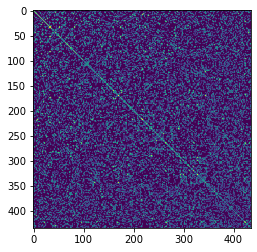

In [3]:
A = nx.adjacency_matrix(graph).todense()
plt.imshow(A)

In [4]:
features = pd.DataFrame.from_dict({n: graph.nodes[n] for n in graph.nodes}, orient='index')

# nodes are in a 1x1 square, so max distance is sqrt(2)
features['dist'] /= np.sqrt(2)
features['dist_to_depot'] /= np.sqrt(2)

features['nn'] = features['nn'].astype(int)
features['in_sol'] = features['in_sol'].astype(int)

features.head()

dist  dist_to_depot  nn  in_sol
12 17  0.511792       0.389392   0       0
   28  0.509440       0.308532   0       0
2  25  0.393396       0.239949   0       0
9  25  0.457487       0.251759   0       0
0  18  0.182209       0.091104   0       0

In [5]:
X = torch.FloatTensor(features.values[:, :-1])
Y = torch.FloatTensor(features.values[:, -1])

# class weights
w = (len(Y) - Y.sum())/Y.sum()
W = torch.ones_like(Y)
W[torch.where(Y)] = w

G = dgl.from_networkx(graph)

In [6]:
import dgl.nn
import torch.nn as nn
import torch.nn.functional as functional

class Net(nn.Module):
    def __init__(self, embedding_dim, n_msg_layers, n_decision_layers, decision_dim):
        super().__init__()
        
        self.embedding_layer = nn.Linear(3, embedding_dim)
        
        self.msg_layers = nn.ModuleList(
            [dgl.nn.GraphConv(embedding_dim, embedding_dim) for _ in range(n_msg_layers)]
        )
        
        self.decision_layers = nn.ModuleList(
            [nn.Linear(embedding_dim, decision_dim)] + \
            [nn.Linear(decision_dim, decision_dim) for _ in range(n_decision_layers - 1)]
        )

        self.output_layer = nn.Linear(decision_dim, 1)
        
        
    def forward(self, g, i):      
        h = self.embedding_layer(i)
        
        for l in self.msg_layers:
            h = functional.relu(l(g, h))
        
        for l in self.decision_layers:
            h = functional.relu(l(h))
        
        o = torch.sigmoid(self.output_layer(h))
        
        return o
    
net = Net(150, 10, 3, 100)
net

Net(
  (embedding_layer): Linear(in_features=3, out_features=150, bias=True)
  (msg_layers): ModuleList(
    (0): GraphConv(in=150, out=150, normalization=both, activation=None)
    (1): GraphConv(in=150, out=150, normalization=both, activation=None)
    (2): GraphConv(in=150, out=150, normalization=both, activation=None)
    (3): GraphConv(in=150, out=150, normalization=both, activation=None)
    (4): GraphConv(in=150, out=150, normalization=both, activation=None)
    (5): GraphConv(in=150, out=150, normalization=both, activation=None)
    (6): GraphConv(in=150, out=150, normalization=both, activation=None)
    (7): GraphConv(in=150, out=150, normalization=both, activation=None)
    (8): GraphConv(in=150, out=150, normalization=both, activation=None)
    (9): GraphConv(in=150, out=150, normalization=both, activation=None)
  )
  (decision_layers): ModuleList(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

pbar = tqdm.trange(100)
for epoch_i in pbar:
    outputs = net(G, X)
    loss = functional.binary_cross_entropy(outputs.squeeze(), Y, weight=W)
    pbar.set_postfix({'Loss': '{:.4f}'.format(loss)})
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()